In [1]:
from data_processing import *
from Max_k_cut_quantum_functions import *
from Max_k_cut_classical_functions import *
from MIS_functions import *

In [2]:
# Set parameters here

p = 7  # the depth of QAOA

ng = 4  # number_of_groups 
    
n = 10  # total number of nodes, or vehicles

mt = 500  # max_time, Start time charging limit (say, after 100 minutes, every car started at least charging)

mct = 100  # max_charging_time, maximum time a car can charge (like 6h)

U = 20  # The size of punishment added to the cost due to including nodes of the same group in the MIS

nshots = 512  # the number of shots per iteration

init_params = [np.pi/8, np.pi]*p  # the initial parameters gammas and betas. This is however unused in the full
                                  # optimization loop since the educated global guess optimization does not require
                                  # initial guesses. The init_params here will be used later to demonstrate the 
                                  # performance of a local optimzation alone.

local_optimization_method = 'Nelder-Mead'  # the local optimization algorithm to be used, supported by Scipy. 
                                      # good candidates include 'Powell', 'COBYLA', 'Nelder-Mead', 'BFGS'

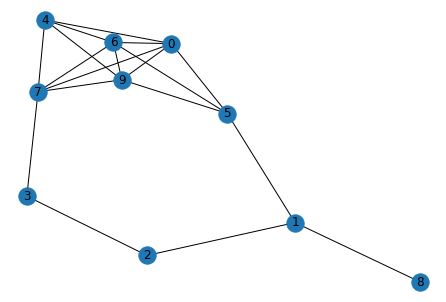

In [3]:
G = generate_data_mis(ng,n,500,100)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show()

In [4]:
adj = get_adjacency_matrix(G)

In [5]:
mb = make_cost_block_MIS(n,1)  # building the mixing block
mb.draw()

┌─────────┐
q_0: ┤ RZ(-γ1) ├
     ├─────────┤
q_1: ┤ RZ(-γ1) ├
     ├─────────┤
q_2: ┤ RZ(-γ1) ├
     ├─────────┤
q_3: ┤ RZ(-γ1) ├
     ├─────────┤
q_4: ┤ RZ(-γ1) ├
     ├─────────┤
q_5: ┤ RZ(-γ1) ├
     ├─────────┤
q_6: ┤ RZ(-γ1) ├
     ├─────────┤
q_7: ┤ RZ(-γ1) ├
     ├─────────┤
q_8: ┤ RZ(-γ1) ├
     ├─────────┤
q_9: ┤ RZ(-γ1) ├
     └─────────┘

In [6]:
cb = make_mixing_block_MIS(n, adj, 1)  # building the cost block 
cb.draw()

┌───┐┌────────────┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐»
q_0: ┤ H ├┤ RZ(2.0*β1) ├─░─┤ X ├┤ RZ(β1) ├┤ X ├─░─┤ X ├┤ RZ(β1) ├┤ X ├─░─┤ X ├»
     └───┘└────────────┘ ░ └─┬─┘└────────┘└─┬─┘ ░ └─┬─┘└────────┘└─┬─┘ ░ └─┬─┘»
q_1: ────────────────────░───┼──────────────┼───░───┼──────────────┼───░───┼──»
                         ░   │              │   ░   │              │   ░   │  »
q_2: ────────────────────░───┼──────────────┼───░───┼──────────────┼───░───┼──»
                         ░   │              │   ░   │              │   ░   │  »
q_3: ────────────────────░───┼──────────────┼───░───┼──────────────┼───░───┼──»
                         ░   │              │   ░   │              │   ░   │  »
q_4: ────────────────────░───■──────────────■───░───┼──────────────┼───░───┼──»
                         ░                      ░   │              │   ░   │  »
q_5: ────────────────────░──────────────────────░───■──────────────■───░───┼──»
                         ░                      ░                      ░   │  »
q_6: ────────────────────░──────────────────────░──────────────────────░───■──»
                         ░                      ░                      ░      »
q_7: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
q_8: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
q_9: ────────────────────░──────────────────────░──────────────────────░──────»
                         ░                      ░                      ░      »
«     ┌────────┐┌───┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐┌────────┐┌───┐ ░      »
«q_0: ┤ RZ(β1) ├┤ X ├─░─┤ X ├┤ RZ(β1) ├┤ X ├─░─┤ X ├┤ RZ(β1) ├┤ X ├─░──────»
«     └────────┘└─┬─┘ ░ └─┬─┘└────────┘└─┬─┘ ░ └─┬─┘└────────┘└─┬─┘ ░      »
«q_1: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░──────»
«                 │   ░   │              │   ░   │              │   ░      »
«q_2: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░──────»
«                 │   ░   │              │   ░   │              │   ░      »
«q_3: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░──────»
«                 │   ░   │              │   ░   │              │   ░      »
«q_4: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░───■──»
«                 │   ░   │              │   ░   │              │   ░ ┌─┴─┐»
«q_5: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░─┤ X ├»
«                 │   ░   │              │   ░   │              │   ░ └───┘»
«q_6: ────────────■───░───┼──────────────┼───░───┼──────────────┼───░──────»
«                     ░   │              │   ░   │              │   ░      »
«q_7: ────────────────░───■──────────────■───░───┼──────────────┼───░──────»
«                     ░                      ░   │              │   ░      »
«q_8: ────────────────░──────────────────────░───┼──────────────┼───░──────»
«                     ░                      ░   │              │   ░      »
«q_9: ────────────────░──────────────────────░───■──────────────■───░──────»
«                     ░                      ░                      ░      »
«     ┌───┐┌──────────┐┌───┐      ░      ┌───┐┌──────────┐┌───┐      ░      »
«q_0: ┤ X ├┤ RZ(β1/2) ├┤ X ├──────░──────┤ X ├┤ RZ(β1/2) ├┤ X ├──────░──────»
«     └─┬─┘└──────────┘└─┬─┘      ░      └─┬─┘└──────────┘└─┬─┘      ░      »
«q_1: ──┼────────────────┼────────░────────┼────────────────┼────────░──────»
«       │                │        ░        │                │        ░      »
«q_2: ──┼────────────────┼────────░────────┼────────────────┼────────░──────»
«       │                │        ░        │                │        ░      »
«q_3: ──┼────────────────┼────────░────────┼────────────────┼────────░──────»
«       │                │        ░        │                │        ░      »
«q_4: 

In [7]:
circ = make_full_circuit_MIS(n,adj,p)  # building the full circuit
circ.decompose().draw()

┌─────────┐┌───┐┌────────────┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐»
    q_0: ┤ RZ(-γ0) ├┤ H ├┤ RZ(2.0*β0) ├─░─┤ X ├┤ RZ(β0) ├┤ X ├─░─┤ X ├»
         ├─────────┤└───┘└────────────┘ ░ └─┬─┘└────────┘└─┬─┘ ░ └─┬─┘»
    q_1: ┤ RZ(-γ0) ├────────────────────░───┼──────────────┼───░───┼──»
         ├─────────┤                    ░   │              │   ░   │  »
    q_2: ┤ RZ(-γ0) ├────────────────────░───┼──────────────┼───░───┼──»
         ├─────────┤                    ░   │              │   ░   │  »
    q_3: ┤ RZ(-γ0) ├────────────────────░───┼──────────────┼───░───┼──»
         ├─────────┤                    ░   │              │   ░   │  »
    q_4: ┤ RZ(-γ0) ├────────────────────░───■──────────────■───░───┼──»
         ├─────────┤                    ░                      ░   │  »
    q_5: ┤ RZ(-γ0) ├────────────────────░──────────────────────░───■──»
         ├─────────┤                    ░                      ░      »
    q_6: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         ├─────────┤                    ░                      ░      »
    q_7: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         ├─────────┤                    ░                      ░      »
    q_8: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         ├─────────┤                    ░                      ░      »
    q_9: ┤ RZ(-γ0) ├────────────────────░──────────────────────░──────»
         └─────────┘                    ░                      ░      »
meas: 10/═════════════════════════════════════════════════════════════»
                                                                      »
«         ┌────────┐┌───┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐»
«    q_0: ┤ RZ(β0) ├┤ X ├─░─┤ X ├┤ RZ(β0) ├┤ X ├─░─┤ X ├┤ RZ(β0) ├┤ X ├─░─┤ X ├»
«         └────────┘└─┬─┘ ░ └─┬─┘└────────┘└─┬─┘ ░ └─┬─┘└────────┘└─┬─┘ ░ └─┬─┘»
«    q_1: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░───┼──»
«                     │   ░   │              │   ░   │              │   ░   │  »
«    q_2: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░───┼──»
«                     │   ░   │              │   ░   │              │   ░   │  »
«    q_3: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░───┼──»
«                     │   ░   │              │   ░   │              │   ░   │  »
«    q_4: ────────────┼───░───┼──────────────┼───░───┼──────────────┼───░───┼──»
«                     │   ░   │              │   ░   │              │   ░   │  »
«    q_5: ────────────■───░───┼──────────────┼───░───┼──────────────┼───░───┼──»
«                         ░   │              │   ░   │              │   ░   │  »
«    q_6: ────────────────░───■──────────────■───░───┼──────────────┼───░───┼──»
«                         ░                      ░   │              │   ░   │  »
«    q_7: ────────────────░──────────────────────░───■──────────────■───░───┼──»
«                         ░                      ░                      ░   │  »
«    q_8: ────────────────░──────────────────────░──────────────────────░───┼──»
«                         ░                      ░                      ░   │  »
«    q_9: ────────────────░──────────────────────░──────────────────────░───■──»
«                         ░                      ░                      ░      »
«meas: 10/═════════════════════════════════════════════════════════════════════»
«                                                                              »
«         ┌────────┐┌───┐ ░      ┌───┐┌──────────┐┌───┐      ░      ┌───┐»
«    q_0: ┤ RZ(β0) ├┤ X ├─░──────┤ X ├┤ RZ(β0/2) ├┤ X ├──────░──────┤ X ├»
«         └────────┘└─┬─┘ ░      └─┬─┘└──────────┘└─┬─┘      ░      └─┬─┘»
«    q_1: ────────────┼───░────────┼────────────────┼────────░────────┼──»
«                     │   ░        │                │        ░        │  »
«    q_2: ────────────┼───░────────┼────────────────┼────────░────────┼──»
«                     │   ░        │    

In [8]:
counts, transpiled_circ = run_circuit(circ, init_params, nshots=nshots)  # visualize the circuit to be runned
transpiled_circ.decompose().draw()

global phase: -11π/16
         ┌───────────────┐ ░ ┌───┐┌─────────┐┌───┐ ░ ┌───┐┌─────────┐┌───┐ ░ »
    q_0: ┤ U3(π/2,π/4,0) ├─░─┤ X ├┤ U1(π/8) ├┤ X ├─░─┤ X ├┤ U1(π/8) ├┤ X ├─░─»
         └───┬────────┬──┘ ░ └─┬─┘└─────────┘└─┬─┘ ░ └─┬─┘└─────────┘└─┬─┘ ░ »
    q_1: ────┤ U1(-π) ├────░───┼───────────────┼───░───┼───────────────┼───░─»
             ├────────┤    ░   │               │   ░   │               │   ░ »
    q_2: ────┤ U1(-π) ├────░───┼───────────────┼───░───┼───────────────┼───░─»
             ├────────┤    ░   │               │   ░   │               │   ░ »
    q_3: ────┤ U1(-π) ├────░───┼───────────────┼───░───┼───────────────┼───░─»
             ├────────┤    ░   │               │   ░   │               │   ░ »
    q_4: ────┤ U1(-π) ├────░───■───────────────■───░───┼───────────────┼───░─»
             ├────────┤    ░                       ░   │               │   ░ »
    q_5: ────┤ U1(-π) ├────░───────────────────────░───■───────────────■───░─»
             ├────────┤    ░                       ░                       ░ »
    q_6: ────┤ U1(-π) ├────░───────────────────────░───────────────────────░─»
             ├────────┤    ░                       ░                       ░ »
    q_7: ────┤ U1(-π) ├────░───────────────────────░───────────────────────░─»
             ├────────┤    ░                       ░                       ░ »
    q_8: ────┤ U1(-π) ├────░───────────────────────░───────────────────────░─»
             ├────────┤    ░                       ░                       ░ »
    q_9: ────┤ U1(-π) ├────░───────────────────────░───────────────────────░─»
             └────────┘    ░                       ░                       ░ »
meas: 10/════════════════════════════════════════════════════════════════════»
                                                                             »
«         ┌───┐┌─────────┐┌───┐ ░ ┌───┐┌─────────┐┌───┐ ░ ┌───┐┌─────────┐┌───┐»
«    q_0: ┤ X ├┤ U1(π/8) ├┤ X ├─░─┤ X ├┤ U1(π/8) ├┤ X ├─░─┤ X ├┤ U1(π/8) ├┤ X ├»
«         └─┬─┘└─────────┘└─┬─┘ ░ └─┬─┘└─────────┘└─┬─┘ ░ └─┬─┘└─────────┘└─┬─┘»
«    q_1: ──┼───────────────┼───░───┼───────────────┼───░───┼───────────────┼──»
«           │               │   ░   │               │   ░   │               │  »
«    q_2: ──┼───────────────┼───░───┼───────────────┼───░───┼───────────────┼──»
«           │               │   ░   │               │   ░   │               │  »
«    q_3: ──┼───────────────┼───░───┼───────────────┼───░───┼───────────────┼──»
«           │               │   ░   │               │   ░   │               │  »
«    q_4: ──┼───────────────┼───░───┼───────────────┼───░───┼───────────────┼──»
«           │               │   ░   │               │   ░   │               │  »
«    q_5: ──┼───────────────┼───░───┼───────────────┼───░───┼───────────────┼──»
«           │               │   ░   │               │   ░   │               │  »
«    q_6: ──■───────────────■───░───┼───────────────┼───░───┼───────────────┼──»
«                               ░   │               │   ░   │               │  »
«    q_7: ──────────────────────░───■───────────────■───░───┼───────────────┼──»
«                               ░                       ░   │               │  »
«    q_8: ──────────────────────░───────────────────────░───┼───────────────┼──»
«                               ░                       ░   │               │  »
«    q_9: ──────────────────────░───────────────────────░───■───────────────■──»
«                               ░                       ░                      »
«meas: 10/═════════════════════════════════════════════════════════════════════»
«                                                                              »
«          ░      ┌───┐┌──────────┐┌───┐      ░      ┌───┐┌──────────┐┌───┐»
«    q_0: ─░──────┤ X ├┤ U1(π/16) ├┤ X ├──────░──────┤ X ├┤ U1(π/16) ├┤ X ├»
«          ░      └─┬─┘└──────────┘└─┬─┘      ░      └─┬─┘└──────────┘└─┬─┘»
«    q_1: ─░────────┼────────────────┼────────░────────┼───────────

In [9]:
average_cost = compute_cost_MIS(counts,adj, U)
average_cost

89.265625

In [10]:
func_to_optimize = func_to_optimize_wrapper_MIS(circ, adj, U, nshots=512, simulator='aer_simulator')